In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

## Load Data

In [2]:
#The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
#The MNIST data-set has now been loaded and consists of 70.000 images and associated labels 
#(i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets.
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [4]:
data.train.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
#The data-set has been loaded as so-called One-Hot encoding. 
#This means the labels have been converted from a single number to a vector whose length equals the number of possible
#classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. 
#For example, the One-Hot encoded labels for the first 5 images in the test-set are:
data.test.labels[0:5, :]


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
#We also need the classes as single numbers for various comparisons and performance measures -cls(class)

In [7]:
data.test.cls[0:5]


array([7, 2, 1, 0, 4])

In [10]:
#In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. 
#This means the numbers only have to be changed in one single place.

# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [11]:
#plot images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

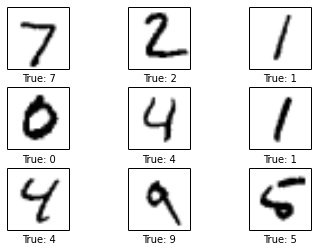

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow
#### A TensorFlow graph consists of the following parts which will be detailed below:
#### Placeholder variables used to change the input to the graph.
#### Model variables that are going to be optimized so as to make the model perform better.
#### The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
#### A cost measure that can be used to guide the optimization of the variables.
#### An optimization method which updates the variables of the model.



In [64]:
#Placeholder variables serve as the input to the graph that we may change each time we execute the graph. 
#We call this feeding the placeholder variables and it is demonstrated further below.

#First we define the placeholder variable for the input images.
x = tf.placeholder(tf.float32, [None, img_size_flat])

#Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. 
y_true = tf.placeholder(tf.float32, [None, num_classes])

#Finally we have the placeholder variable for the true class of each image in the placeholder variable x.
y_true_cls = tf.placeholder(tf.int64, [None])


In [65]:
#The first variable that must be optimized is called weights and is defined here as a TensorFlow variable 
#that must be initialized with zeros
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))


In [66]:
#The second variable that must be optimized is called biases
biases = tf.Variable(tf.zeros([num_classes]))


## Model
This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.
The result is a matrix of shape [num_images, num_classes] because x has shape [num_images, img_size_flat] and weights has shape [img_size_flat, num_classes], so the multiplication of those two matrices is a matrix with shape [num_images, num_classes] and then the biases vector is added to each row of that matrix.
Note that the name logits is typical TensorFlow terminology, but other people may call the variable something else.

In [67]:
logits = tf.matmul(x, weights) + biases


Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.
However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [68]:
y_pred = tf.nn.softmax(logits)


In [69]:
#The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.
y_pred_cls = tf.argmax(y_pred, dimension=1)


### Cost-function to be optimized
To make the model better at classifying the input images, we must somehow change the variables for weights and biases. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.
TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [70]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

In [71]:

#We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well 
#the model performs on each image individually. 
cost = tf.reduce_mean(cross_entropy)

In [72]:
#Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to 
#the TensorFlow graph for later execution.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.3).minimize(cost)


In [73]:
#This is a vector of booleans whether the predicted class equals the true class of each image.
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


In [74]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## TensorFlow Run
### Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.



In [75]:
session = tf.Session()

### Initialize variables
The variables for weights and biases must be initialized before we start optimizing them.



In [76]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations
There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.



In [77]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the weights and biases of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.


In [78]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions to show performance
Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the placeholder variables in the TensorFlow graph.



In [79]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [80]:
# accuracy
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))


In [81]:
# confusion matrix
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [82]:
#plotting misclassified images
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot the model weights
Function for plotting the weights of the model. 10 images are plotted, one for each digit that the model is trained to recognize.



In [83]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Performance before any optimization
The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [84]:
print_accuracy()


Accuracy on test-set: 9.8%


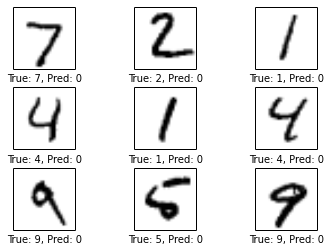

In [85]:
plot_example_errors()


### Performance after 1 optimization iteration
Already after a single optimization iteration, the model has increased its accuracy on the test-set to 40.7% up from 9.8%. This means that it mis-classifies the images about 6 out of 10 times, as demonstrated on a few examples below.




In [86]:
optimize(num_iterations=1)



In [87]:
print_accuracy()
#Accuracy on test-set: 40.7%



Accuracy on test-set: 40.7%


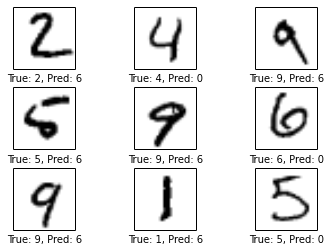

In [88]:
plot_example_errors()

The weights can also be plotted as shown below. Positive weights are red and negative weights are blue. These weights can be intuitively understood as image-filters.
For example, the weights used to determine if an image shows a zero-digit have a positive reaction (red) to an image of a circle, and have a negative reaction (blue) to images with content in the centre of the circle.
Similarly, the weights used to determine if an image shows a one-digit react positively (red) to a vertical line in the centre of the image, and react negatively (blue) to images with content surrounding that line.
Note that the weights mostly look like the digits they're supposed to recognize. This is because only one optimization iteration has been performed so the weights are only trained on 100 images. After training on several thousand images, the weights become more difficult to interpret because they have to recognize many variations of how digits can be written.


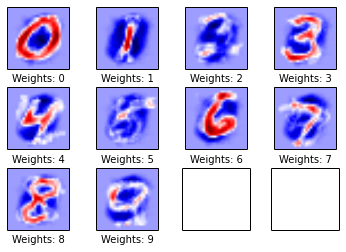

In [89]:
plot_weights()

In [90]:
### Performance after 10 optimization iterations

# We have already performed 1 iteration.
#iteration improves the accuracy
optimize(num_iterations=12)



In [91]:
print_accuracy()



Accuracy on test-set: 79.2%


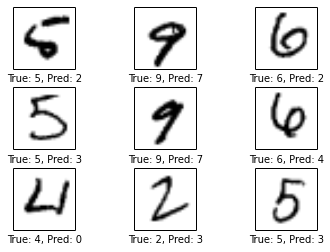

In [92]:
plot_example_errors()

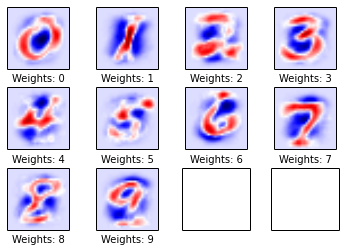

In [93]:
plot_weights()


### Performance after 1000 optimization iterations
After 1000 optimization iterations, the model only mis-classifies about one in ten images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while others are quite obvious and should have been classified correctly by a good model. But this simple model cannot reach much better performance and more complex models are therefore needed.

In [94]:
optimize(num_iterations=988)


In [95]:
print_accuracy()

Accuracy on test-set: 91.9%


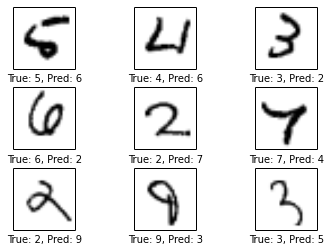

In [96]:
plot_example_errors()

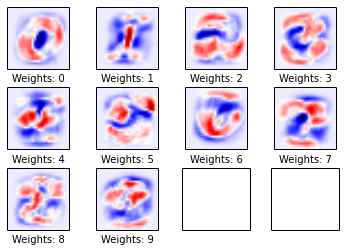

In [97]:
plot_weights()


[[ 958    0    3    1    0    6    9    1    2    0]
 [   0 1103    2    2    1    3    4    1   19    0]
 [   5    5  928   14   12    4   10   12   33    9]
 [   3    0   27  904    0   40    1   10   14   11]
 [   1    1    7    1  904    2   10    2    8   46]
 [   8    3    8   25    7  799   12    3   18    9]
 [  10    3    7    1   12   17  906    1    1    0]
 [   2    9   22    8    7    0    0  935    1   44]
 [   8    9   11   22    9   45   11   13  829   17]
 [   9    6    3   10   23   14    0   14    6  924]]


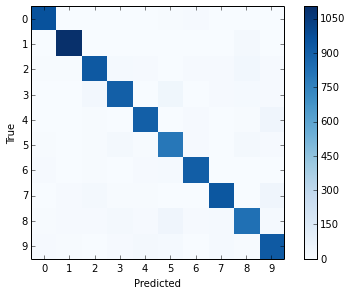

In [98]:
print_confusion_matrix()


### Exercises
These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.
You may want to backup this Notebook before making any changes.
Change the learning-rate for the optimizer.
Change the optimizer to e.g. AdagradOptimizer or AdamOptimizer.
Change the batch-size to e.g. 1 or 1000.
How do these changes affect the performance?
Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
Change the function plot_example_errors() so it also prints the logits and y_pred values for the mis-classified examples.
Use sparse_softmax_cross_entropy_with_logits instead of softmax_cross_entropy_with_logits. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
Remake the program yourself without looking too much at this source-code.
Explain to a friend how the program works.